In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

import density_plot
from config import plot_path, parameter, data_path
import runner

In [2]:
Omega_a_h_sq_harm, theta_i_s, f_a_s = runner.load_data(data_path + "/harmonic.npz")

theta_i_index = 0
Omega_unit = 0.004
Omega = Omega_a_h_sq_harm[theta_i_index, :] / Omega_unit
f_a_unit = 1e28
f_a = f_a_s / f_a_unit

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


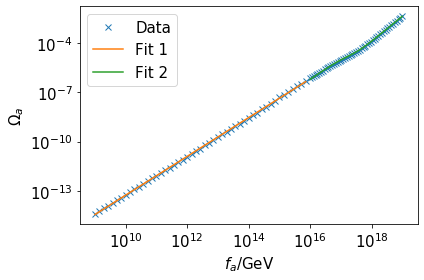

A = 0.00228931373342 +/- 7.04123628313e-05 p = 1.17771942963 +/- 0.00194292773365
B = 0.00425845665524 +/- 7.74055846053e-07 a = 1.86935437284 +/- 0.111778865401 q = 1.52723312892 +/- 0.00060184681972 r = 1.27781538454 +/- 0.0158429713792 fu =  2.16448080955e+26 +/- 1.87213072474e+25
7/6 = 1.1666666666666667 3/2 = 1.5


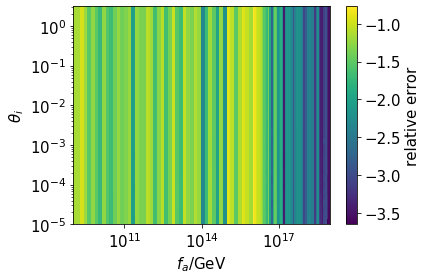

In [18]:
fs = 1e-3

F = lambda log_f, log_A, p: log_A + p * log_f
G = lambda f, B, a, q, r, fu: B * f ** ((r + q * (f / fu)**a) / (1 + (f / fu)**a))

f_a_1st = f_a[f_a < fs]
f_a_2nd = f_a[f_a >= fs]
Omega_1st = Omega[f_a < fs]
Omega_2nd = Omega[f_a >= fs]

(log_A, p), cov = opt.curve_fit(F, np.log10(f_a_1st), np.log10(Omega_1st), p0=(1, 7/6))
log_A_err, p_err = np.diag(np.sqrt(cov))

(B, a, q, r, fu), cov = opt.curve_fit(G, f_a_2nd, Omega_2nd, p0=(0.9, 1, 3/2, 1, 1e-1))
B_err, a_err, q_err, r_err, fu_err = np.sqrt(np.diag(cov))

ax = plt.gca()
ax.tick_params(labelsize=15)
plt.loglog(f_a_unit * f_a / 1e9, Omega_unit * Omega, "x", label="Data")
plt.loglog(f_a_unit * f_a_1st / 1e9, Omega_unit * 10**F(np.log10(f_a_1st), log_A, p), label="Fit 1")
plt.loglog(f_a_unit * f_a_2nd / 1e9, Omega_unit * G(f_a_2nd, B, a, q, r, fu), label="Fit 2")
plt.legend(fontsize=15)
plt.xlabel(r"$f_a / \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\Omega_a$", fontsize=15)
plt.tight_layout()
plt.savefig(plot_path + "/fit_plot.pdf")
plt.show()

F_A, THETA_I = np.meshgrid(f_a_s, theta_i_s)
def fn(f):
    return np.where(f < fs, 10**F(np.log10(f), log_A, p), G(f, B, a, q, r, fu))
Omega_a_h_sq_harm_fit = fn(F_A / f_a_unit) * Omega_unit * THETA_I**2 / theta_i_s[theta_i_index]**2
rel_err = np.abs(Omega_a_h_sq_harm - Omega_a_h_sq_harm_fit) / Omega_a_h_sq_harm
fig = plt.gcf()
ax = plt.gca()
ax.tick_params(labelsize=15)
ax.set_xscale("log")
ax.set_yscale("log")
plt.pcolormesh(f_a_s / 1e9, theta_i_s, np.log10(rel_err))
plt.xlabel(r"$f_a / \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\theta_i$", fontsize=15)
cbar = plt.colorbar()
cbar.ax.set_ylabel("relative error", fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()
plt.savefig(plot_path + "/fit_error_plot.pdf")

A = Omega_unit * 10**log_A
B = Omega_unit * B
A_err = Omega_unit * log_A_err * np.log(10) * np.exp(np.log(10) * log_A)
B_err = Omega_unit * B_err
fu = f_a_unit * fu
fu_err = f_a_unit * fu_err
print("A =", A, "+/-", A_err, "p =", p, "+/-", p_err)
print("B =", B, "+/-", B_err, "a =", a, "+/-", a_err, "q =", q, "+/-", q_err, "r =", r, "+/-", r_err, "fu = ",
     fu, "+/-", fu_err)                                
print("7/6 =", 7/6, "3/2 =", 3/2)